<a href="https://colab.research.google.com/github/minzadinov/HPC-2023/blob/main/bilinear/bilinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import numpy as np
import numba
import cv2
from google.colab.patches import cv2_imshow
import time
import matplotlib.pyplot as plt

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
@numba.njit
def bilinear_interpolation_gpu(image, output_shape):
    src_h, src_w = image.shape[:2]
    dst_h, dst_w = output_shape[:2]

    # Compute scale factors
    sh = src_h / dst_h
    sw = src_w / dst_w

    # Create output image
    output_image = np.zeros(output_shape, dtype=np.float32)

    for i in range(dst_h):
        for j in range(dst_w):
            # Calculate the coordinate in the source image
            y = i * sh
            x = j * sw

            # Compute the integer part of the coordinates
            y_int = int(y)
            x_int = int(x)

            # Compute the fractional part of the coordinates
            y_frac = y - y_int
            x_frac = x - x_int

            y_int_next = min(y_int + 1, src_h - 1)
            x_int_next = min(x_int + 1, src_w - 1)

            # Perform bilinear interpolation
            output_image[i, j] = (
                (1 - x_frac) * (1 - y_frac) * image[y_int, x_int] +
                (1 - x_frac) * y_frac * image[y_int_next, x_int] +
                x_frac * (1 - y_frac) * image[y_int, x_int_next] +
                x_frac * y_frac * image[y_int_next, x_int_next]
            )

    return output_image

In [65]:
def bilinear_interpolation_cpu(image, new_size):
    # Получаем размеры исходного и нового изображений
    height, width = image.shape[:2]
    new_height, new_width = new_size[:2]

    # Вычисляем коэффициенты масштабирования по каждой оси
    scale_x = float(width) / new_width
    scale_y = float(height) / new_height

    # Инициализируем новое изображение заданного размера
    output_image = np.zeros(new_size, dtype=np.float32)

    for y in range(new_height):
        for x in range(new_width):
            # Находим координаты соответствующие текущей позиции в новом изображении
            src_x = (x + 0.5) * scale_x - 0.5
            src_y = (y + 0.5) * scale_y - 0.5

            # Находим координаты ближайших пикселей в исходном изображении
            x0 = int(np.floor(src_x))
            x1 = min(x0 + 1, width - 1)
            y0 = int(np.floor(src_y))
            y1 = min(y0 + 1, height - 1)

            # Находим весовые коэффициенты для билинейной интерполяции
            dx = src_x - x0
            dy = src_y - y0

            # Вычисляем значения пикселей в новом изображении с помощью билинейной интерполяции
            output_image[y, x] = (1 - dx) * (1 - dy) * image[y0, x0] \
                                        + dx * (1 - dy) * image[y0, x1] \
                                        + (1 - dx) * dy * image[y1, x0] \
                                        + dx * dy * image[y1, x1]
    return output_image

In [59]:
def cpu_with_time (image, new_size):
  start_time = time.time()
  bilinear_interpolation_cpu(image, new_size)
  end_time = time.time()
  execution_time = end_time - start_time
  return execution_time

def gpu_with_time (image, new_size):
  start_time = time.time()
  bilinear_interpolation_gpu(image, new_size)
  end_time = time.time()
  execution_time = end_time - start_time
  return execution_time

Based original


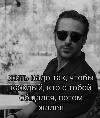

In [75]:
image = cv2.imread("/content/drive/MyDrive/HPC/bilinear/based.jpg", cv2.IMREAD_GRAYSCALE)
print("Based original")
cv2_imshow(image)

Based interpolated


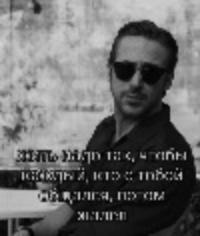

In [76]:
new_size = (image.shape[0] * 2, image.shape[1] * 2)
resized_image = cv2.resize(image, new_size)
output_image = bilinear_interpolation_gpu(resized_image, new_size)
cv2.imwrite("/content/drive/MyDrive/HPC/bilinear/interpolated_and_based.jpg", output_image)
print("Based interpolated")
cv2_imshow(output_image)

In [84]:
iterations = 5
size_mult = 2
label_x = "Коэфициэнт интерполяции"
label_y = "Время суммирования элементов, сек"

cpu_times = []
gpu_times = []
iter_list = []

for i in range(iterations):
  new_iter_size = (image.shape[0] * size_mult, image.shape[1] * size_mult)
  iter_resized_image = cv2.resize(image, new_iter_size)
  cpu_times.append(cpu_with_time(iter_resized_image, new_iter_size))
  gpu_times.append(gpu_with_time(iter_resized_image, new_iter_size))
  iter_list.append(i)
  size_mult = size_mult + 1

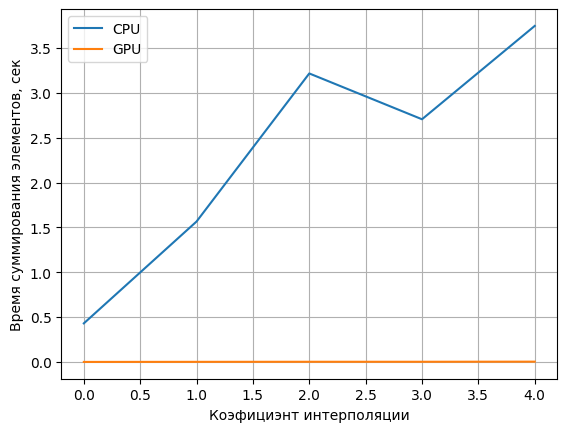

In [85]:
    plt.plot(iter_list, cpu_times, label='CPU')
    plt.legend()
    plt.plot(iter_list, gpu_times, label='GPU')
    plt.legend()
    plt.grid()
    plt.xlabel(label_x)
    plt.ylabel(label_y)

    plt.savefig("/content/drive/MyDrive/HPC/bilinear/bilinear_plot.png")
    plt.show()